## Download dataset

In [1]:
# !wget https://malaya-dataset.s3-ap-southeast-1.amazonaws.com/jawi-rumi.tar.gz
# !wget https://raw.githubusercontent.com/huseinzol05/Malaya-Dataset/master/ocr/train-test-rumi-to-jawi.json
# !tar -zxf jawi-rumi.tar.gz

In [2]:
import json

with open('train-test-rumi-to-jawi.json') as fopen:
    dataset = json.load(fopen)
len(dataset['train']), len(dataset['test'])

(24840, 6211)

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.misc import imresize
import cv2

/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [4]:
train_labels = [f.split('/')[1].split('.')[0].lower() for f in dataset['train']]
test_labels = [f.split('/')[1].split('.')[0].lower() for f in dataset['test']]

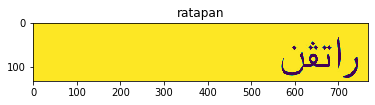

In [5]:
plt.imshow(cv2.imread(dataset['train'][0], 0).astype(np.float32)/255.)
plt.title(train_labels[0])
plt.show()

In [6]:
charset = list(set(''.join(train_labels + test_labels)))
num_classes = len(charset) + 2
encode_maps = {}
decode_maps = {}
for i, char in enumerate(charset, 1):
    encode_maps[char] = i
    decode_maps[i] = char
    
SPACE_INDEX = 0
SPACE_TOKEN = '<PAD>'
encode_maps[SPACE_TOKEN] = SPACE_INDEX
decode_maps[SPACE_INDEX] = SPACE_TOKEN

In [7]:
encode_maps

{'h': 1,
 'g': 2,
 't': 3,
 'n': 4,
 'j': 5,
 'y': 6,
 'f': 7,
 's': 8,
 'a': 9,
 'c': 10,
 '-': 11,
 'v': 12,
 '?': 13,
 'q': 14,
 'e': 15,
 'w': 16,
 ' ': 17,
 'p': 18,
 'o': 19,
 'b': 20,
 'r': 21,
 'l': 22,
 'i': 23,
 "'": 24,
 'u': 25,
 'k': 26,
 'm': 27,
 'd': 28,
 'z': 29,
 'x': 30,
 '<PAD>': 0}

In [8]:
[encode_maps[c] for c in train_labels[0]]

[21, 9, 3, 9, 18, 9, 4]

In [9]:
image_height = 60
image_width = 240
image_channel = 1
max_stepsize = 128
num_hidden = 256
epoch = 20
batch_size = 128
initial_learning_rate = 1e-3

## Our input image after transformation

/home/husein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


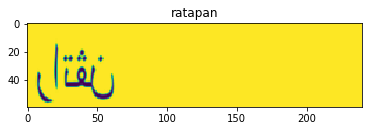

In [10]:
resized = imresize(cv2.flip((cv2.imread(dataset['train'][0], 0).astype(np.float32)/255.), 1), (image_height,
                                                                        image_width,
                                                                        image_channel))
plt.imshow(resized)
plt.title(train_labels[0])
plt.show()

In [11]:
import tqdm
train_X = []
for img in tqdm.tqdm(dataset['train']):
    resized = imresize(cv2.flip((cv2.imread(img, 0).astype(np.float32)/255.), 1), (image_height,
                                                                        image_width,
                                                                        image_channel))
    train_X.append(resized)

  0%|          | 0/24840 [00:00<?, ?it/s]/home/husein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  
100%|██████████| 24840/24840 [01:02<00:00, 397.42it/s]


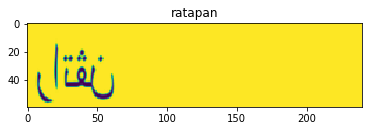

In [12]:
plt.imshow(train_X[0])
plt.title(train_labels[0])
plt.show()

In [13]:
import tqdm
test_X = []
for img in tqdm.tqdm(dataset['test']):
    resized = imresize(cv2.flip((cv2.imread(img, 0).astype(np.float32)/255.), 1), (image_height,
                                                                        image_width,
                                                                        image_channel))
    test_X.append(resized)

  0%|          | 0/6211 [00:00<?, ?it/s]/home/husein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  
100%|██████████| 6211/6211 [00:15<00:00, 394.32it/s]


In [14]:
train_Y = []
for label in train_labels:
    train_Y.append([encode_maps[c] for c in label])
    
test_Y = []
for label in test_labels:
    test_Y.append([encode_maps[c] for c in label])

In [15]:
def pad_second_dim(x, desired_size):
    padding = tf.tile([[0]], tf.stack([tf.shape(x)[0], desired_size - tf.shape(x)[1]], 0))
    return tf.concat([x, padding], 1)

class Model:
    def __init__(self):
        self.X = tf.placeholder(tf.float32, [None, image_height, image_width, image_channel])
        self.Y = tf.sparse_placeholder(tf.int32)
        self.SEQ_LEN = tf.placeholder(tf.int32, [None])
        self.label = tf.placeholder(tf.int32, [None, None])
        self.Y_seq_len = tf.placeholder(tf.int32, [None])
        batch_size = tf.shape(self.X)[0]
        filters = [64, 128, 128, max_stepsize]
        strides = [1, 2]
        x = self.conv2d(self.X, 'cnn-1', 3, 1, filters[0], strides[0])
        x = self.batch_norm('bn1', x)
        x = self.leaky_relu(x, 0.01)
        x = self.max_pool(x, 2, strides[1])
        x = self.conv2d(x, 'cnn-2', 3, filters[0], filters[1], strides[0])
        x = self.batch_norm('bn2', x)
        x = self.leaky_relu(x, 0.01)
        x = self.max_pool(x, 2, strides[1])
        x = self.conv2d(x, 'cnn-3', 3, filters[1], filters[2], strides[0])
        x = self.batch_norm('bn3', x)
        x = self.leaky_relu(x, 0.01)
        x = self.max_pool(x, 2, strides[1])
        x = self.conv2d(x, 'cnn-4', 3, filters[2], filters[3], strides[0])
        x = self.batch_norm('bn4', x)
        x = self.leaky_relu(x, 0.01)
        x = self.max_pool(x, 2, strides[1])
        print(x)
        x = tf.reshape(x, [batch_size, -1, filters[3]])
        x = tf.transpose(x, [0, 2, 1])
        x = tf.reshape(x, [batch_size, filters[3], 4 * 15])
        cell = tf.contrib.rnn.LSTMCell(num_hidden)
        cell1 = tf.contrib.rnn.LSTMCell(num_hidden)
        stack = tf.contrib.rnn.MultiRNNCell([cell, cell1])
        outputs, _ = tf.nn.dynamic_rnn(stack, x, self.SEQ_LEN, dtype=tf.float32)
        outputs = tf.reshape(outputs, [-1, num_hidden])
        self.logits = tf.layers.dense(outputs, num_classes)
        shape = tf.shape(x)
        self.logits = tf.reshape(self.logits, [shape[0], -1, num_classes])
        self.logits = tf.transpose(self.logits, (1, 0, 2))
        self.global_step = tf.Variable(0, trainable=False)
        self.loss = tf.nn.ctc_loss(labels=self.Y,
                                   inputs=self.logits,
                                   sequence_length=self.SEQ_LEN)
        self.cost = tf.reduce_mean(self.loss)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=initial_learning_rate).minimize(self.cost)
        self.decoded, self.log_prob = tf.nn.ctc_beam_search_decoder(self.logits,
                                                                    self.SEQ_LEN,
                                                                    merge_repeated=False)
        decoded = tf.to_int32(self.decoded[0])
        self.dense_decoded = tf.sparse_tensor_to_dense(decoded)
        
        preds = self.dense_decoded[:, :tf.reduce_max(self.Y_seq_len)]
        masks = tf.sequence_mask(self.Y_seq_len, tf.reduce_max(self.Y_seq_len), dtype=tf.float32)
        preds = pad_second_dim(preds, tf.reduce_max(self.Y_seq_len))
        y_t = tf.cast(preds, tf.int32)
        self.prediction = tf.boolean_mask(y_t, masks)
        mask_label = tf.boolean_mask(self.label, masks)
        self.mask_label = mask_label
        correct_pred = tf.equal(self.prediction, mask_label)
        correct_index = tf.cast(correct_pred, tf.float32)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        
    def conv2d(self, x, name, filter_size, channel_in, channel_out, strides):
        with tf.variable_scope(name):
            return tf.layers.conv2d(x, channel_out, filter_size, strides, padding='SAME')
        
    
    def batch_norm(self, name, x):
        with tf.variable_scope(name):
            params_shape = [x.get_shape()[-1]]
            beta = tf.get_variable('beta', params_shape, tf.float32,
                                   initializer=tf.constant_initializer(0.0, tf.float32))
            gamma = tf.get_variable('gamma', params_shape, tf.float32,
                                    initializer=tf.constant_initializer(1.0, tf.float32))
            mean, variance = tf.nn.moments(x, [0, 1, 2], name='moments')
            x_bn = tf.nn.batch_normalization(x, mean, variance, beta, gamma, 0.001)
            x_bn.set_shape(x.get_shape())
            return x_bn
        
    def leaky_relu(self, x, leak=0):
        return tf.where(tf.less(x, 0.0), leak * x, x, name='leaky_relu')
    
    def max_pool(self, x, size, strides):
        return tf.nn.max_pool(x, 
                              ksize=[1, size, size, 1],
                              strides=[1, strides, strides, 1],
                              padding='SAME',
                              name='max_pool')

In [16]:
def sparse_tuple_from_label(sequences, dtype=np.int32):
    indices, values = [], []
    for n, seq in enumerate(sequences):
        indices.extend(zip([n] * len(seq), range(len(seq))))
        values.extend(seq)
    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1] + 1], dtype=np.int64)
    return indices, values, shape


def pad_sentence_batch(sentence_batch, pad_int):
    padded_seqs = []
    seq_lens = []
    max_sentence_len = max([len(sentence) for sentence in sentence_batch])
    for sentence in sentence_batch:
        padded_seqs.append(sentence + [pad_int] * (max_sentence_len - len(sentence)))
        seq_lens.append(len(sentence))
    return padded_seqs, seq_lens

In [17]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model()
sess.run(tf.global_variables_initializer())

W0821 00:37:19.885069 139876468983616 deprecation.py:323] From <ipython-input-15-3fc8a36d5ad0>:70: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0821 00:37:19.890462 139876468983616 deprecation.py:506] From /home/husein/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0821 00:37:20.133772 139876468983616 deprecation.py:506] From <ipython-input-15-3fc8a36d5ad0>:77: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passi

Tensor("max_pool_3:0", shape=(?, 4, 15, 128), dtype=float32)


W0821 00:37:20.951928 139876468983616 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0821 00:37:20.953191 139876468983616 deprecation.py:323] From <ipython-input-15-3fc8a36d5ad0>:35: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0821 00:37:20.954526 139876468983616 deprecation.py:323] From <ipython-input-15-3fc8a36d5ad0>:37: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions fo

In [18]:
import time

In [19]:
for e in range(epoch):
    pbar = tqdm.tqdm(
        range(0, len(train_X), batch_size), desc = 'minibatch loop')
    train_loss, train_acc, test_loss, test_acc = [], [], [], []
    total_lost, total_acc = 0, 0
    for i in pbar:
        index = min(i + batch_size, len(train_X))
        batch_x = train_X[i : index]
        batch_x = np.array(batch_x).reshape((len(batch_x), image_height, image_width,image_channel))
        y = train_Y[i : index]
        batch_y = sparse_tuple_from_label(y)
        batch_label, batch_length = pad_sentence_batch(y, 0)
        batch_len = np.asarray([max_stepsize for _ in [1]*len(batch_x)], dtype=np.int64)
        feed = {model.X: batch_x,
                model.Y: batch_y,
                model.SEQ_LEN: batch_len,
               model.label: batch_label,
               model.Y_seq_len: batch_length}
        accuracy, loss, _ = sess.run([model.accuracy,model.cost,model.optimizer],
                                    feed_dict = feed)
        train_loss.append(loss)
        train_acc.append(accuracy)
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    
    
    pbar = tqdm.tqdm(
        range(0, len(test_X), batch_size), desc = 'minibatch loop')
    for i in pbar:
        index = min(i + batch_size, len(test_X))
        batch_x = test_X[i : index]
        batch_x = np.array(batch_x).reshape((len(batch_x), image_height, image_width,image_channel))
        y = test_Y[i : index]
        batch_y = sparse_tuple_from_label(y)
        batch_label, batch_length = pad_sentence_batch(y, 0)
        batch_len = np.asarray([max_stepsize for _ in [1]*len(batch_x)], dtype=np.int64)
        feed = {model.X: batch_x,
                model.Y: batch_y,
                model.SEQ_LEN: batch_len,
               model.label: batch_label,
               model.Y_seq_len: batch_length}
        accuracy, loss = sess.run([model.accuracy,model.cost],
                                    feed_dict = feed)

        test_loss.append(loss)
        test_acc.append(accuracy)
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    
    print('epoch %d, training avg loss %f, training avg acc %f'%(e+1,
                                                                 np.mean(train_loss),np.mean(train_acc)))
    print('epoch %d, testing avg loss %f, testing avg acc %f'%(e+1,
                                                              np.mean(test_loss),np.mean(test_acc)))

minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 1, training avg loss 33.120262, training avg acc 0.009927
epoch 1, testing avg loss 28.771021, testing avg acc 0.014384


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 2, training avg loss 27.930634, training avg acc 0.016064
epoch 2, testing avg loss 27.659239, testing avg acc 0.025133


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 3, training avg loss 25.574694, training avg acc 0.040293
epoch 3, testing avg loss 24.336323, testing avg acc 0.090451


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 4, training avg loss 21.316620, training avg acc 0.130013
epoch 4, testing avg loss 21.977003, testing avg acc 0.201929


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 5, training avg loss 16.991398, training avg acc 0.233791
epoch 5, testing avg loss 15.910910, testing avg acc 0.261684


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 6, training avg loss 13.614714, training avg acc 0.328867
epoch 6, testing avg loss 12.999638, testing avg acc 0.336366


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 7, training avg loss 11.390049, training avg acc 0.385294
epoch 7, testing avg loss 11.285454, testing avg acc 0.387072


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 8, training avg loss 9.895311, training avg acc 0.430822
epoch 8, testing avg loss 10.571463, testing avg acc 0.445215


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 9, training avg loss 8.813237, training avg acc 0.467833
epoch 9, testing avg loss 9.201124, testing avg acc 0.480846


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 10, training avg loss 7.991840, training avg acc 0.498266
epoch 10, testing avg loss 8.456293, testing avg acc 0.506655


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 11, training avg loss 7.305476, training avg acc 0.527048
epoch 11, testing avg loss 8.293816, testing avg acc 0.512018


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 12, training avg loss 6.766893, training avg acc 0.553027
epoch 12, testing avg loss 7.907925, testing avg acc 0.504318


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 13, training avg loss 6.324562, training avg acc 0.575580
epoch 13, testing avg loss 7.463841, testing avg acc 0.526623


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 14, training avg loss 5.962626, training avg acc 0.590173
epoch 14, testing avg loss 7.307707, testing avg acc 0.548483


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 15, training avg loss 5.567712, training avg acc 0.606642
epoch 15, testing avg loss 6.743862, testing avg acc 0.565519


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 16, training avg loss 5.241017, training avg acc 0.624327
epoch 16, testing avg loss 6.719790, testing avg acc 0.560595


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 17, training avg loss 4.994349, training avg acc 0.636391
epoch 17, testing avg loss 6.487906, testing avg acc 0.583636


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 18, training avg loss 4.770884, training avg acc 0.652775
epoch 18, testing avg loss 6.568841, testing avg acc 0.582399


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 19, training avg loss 4.553185, training avg acc 0.659810
epoch 19, testing avg loss 6.492169, testing avg acc 0.585613


minibatch loop: 100%|██████████| 49/49 [02:29<00:00,  2.65s/it, accuracy=0.607, cost=5.5] 

epoch 20, training avg loss 4.369586, training avg acc 0.669185
epoch 20, testing avg loss 6.507473, testing avg acc 0.586389


In [21]:
for e in range(epoch):
    pbar = tqdm.tqdm(
        range(0, len(train_X), batch_size), desc = 'minibatch loop')
    train_loss, train_acc, test_loss, test_acc = [], [], [], []
    total_lost, total_acc = 0, 0
    for i in pbar:
        index = min(i + batch_size, len(train_X))
        batch_x = train_X[i : index]
        batch_x = np.array(batch_x).reshape((len(batch_x), image_height, image_width,image_channel))
        y = train_Y[i : index]
        batch_y = sparse_tuple_from_label(y)
        batch_label, batch_length = pad_sentence_batch(y, 0)
        batch_len = np.asarray([max_stepsize for _ in [1]*len(batch_x)], dtype=np.int64)
        feed = {model.X: batch_x,
                model.Y: batch_y,
                model.SEQ_LEN: batch_len,
               model.label: batch_label,
               model.Y_seq_len: batch_length}
        accuracy, loss, _ = sess.run([model.accuracy,model.cost,model.optimizer],
                                    feed_dict = feed)
        train_loss.append(loss)
        train_acc.append(accuracy)
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    
    
    pbar = tqdm.tqdm(
        range(0, len(test_X), batch_size), desc = 'minibatch loop')
    for i in pbar:
        index = min(i + batch_size, len(test_X))
        batch_x = test_X[i : index]
        batch_x = np.array(batch_x).reshape((len(batch_x), image_height, image_width,image_channel))
        y = test_Y[i : index]
        batch_y = sparse_tuple_from_label(y)
        batch_label, batch_length = pad_sentence_batch(y, 0)
        batch_len = np.asarray([max_stepsize for _ in [1]*len(batch_x)], dtype=np.int64)
        feed = {model.X: batch_x,
                model.Y: batch_y,
                model.SEQ_LEN: batch_len,
               model.label: batch_label,
               model.Y_seq_len: batch_length}
        accuracy, loss = sess.run([model.accuracy,model.cost],
                                    feed_dict = feed)

        test_loss.append(loss)
        test_acc.append(accuracy)
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    
    print('epoch %d, training avg loss %f, training avg acc %f'%(e+1,
                                                                 np.mean(train_loss),np.mean(train_acc)))
    print('epoch %d, testing avg loss %f, testing avg acc %f'%(e+1,
                                                              np.mean(test_loss),np.mean(test_acc)))

minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 1, training avg loss 4.212183, training avg acc 0.680620
epoch 1, testing avg loss 5.973215, testing avg acc 0.611238


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 2, training avg loss 3.999935, training avg acc 0.692431
epoch 2, testing avg loss 6.162646, testing avg acc 0.588004


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 3, training avg loss 3.797749, training avg acc 0.704135
epoch 3, testing avg loss 6.246995, testing avg acc 0.586793


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 4, training avg loss 3.651014, training avg acc 0.710197
epoch 4, testing avg loss 6.173157, testing avg acc 0.598958


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 5, training avg loss 3.553859, training avg acc 0.715041
epoch 5, testing avg loss 6.334903, testing avg acc 0.599753


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 6, training avg loss 3.470239, training avg acc 0.720273
epoch 6, testing avg loss 6.193605, testing avg acc 0.607574


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 7, training avg loss 3.376973, training avg acc 0.724750
epoch 7, testing avg loss 6.256104, testing avg acc 0.615147


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 8, training avg loss 3.137635, training avg acc 0.742743
epoch 8, testing avg loss 6.099587, testing avg acc 0.613780


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 9, training avg loss 2.960249, training avg acc 0.755675
epoch 9, testing avg loss 6.254755, testing avg acc 0.606650


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 10, training avg loss 2.890265, training avg acc 0.759802
epoch 10, testing avg loss 6.291328, testing avg acc 0.604859


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 11, training avg loss 2.798285, training avg acc 0.764506
epoch 11, testing avg loss 6.108732, testing avg acc 0.619570


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 12, training avg loss 2.712242, training avg acc 0.768748
epoch 12, testing avg loss 6.042776, testing avg acc 0.630663


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 13, training avg loss 2.572402, training avg acc 0.780028
epoch 13, testing avg loss 6.241817, testing avg acc 0.614702


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 14, training avg loss 2.481690, training avg acc 0.785314
epoch 14, testing avg loss 6.166565, testing avg acc 0.621831


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 15, training avg loss 2.439349, training avg acc 0.787217
epoch 15, testing avg loss 6.164974, testing avg acc 0.638686


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 16, training avg loss 2.316348, training avg acc 0.794459
epoch 16, testing avg loss 6.346829, testing avg acc 0.630829


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 17, training avg loss 2.203645, training avg acc 0.805378
epoch 17, testing avg loss 6.456281, testing avg acc 0.629946


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 18, training avg loss 2.062423, training avg acc 0.815356
epoch 18, testing avg loss 6.392627, testing avg acc 0.629511


minibatch loop:   0%|          | 0/195 [00:00<?, ?it/s]

epoch 19, training avg loss 1.946490, training avg acc 0.823843
epoch 19, testing avg loss 6.533266, testing avg acc 0.614861


minibatch loop: 100%|██████████| 49/49 [02:27<00:00,  2.62s/it, accuracy=0.634, cost=5.11]

epoch 20, training avg loss 1.880135, training avg acc 0.831593
epoch 20, testing avg loss 6.378660, testing avg acc 0.629094


## Test to classify one of element from test batch

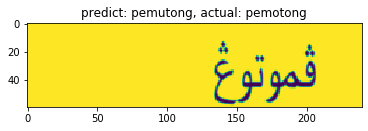

In [34]:
decoded = sess.run(model.dense_decoded, feed_dict = {model.X: batch_x[3:4],
                                          model.SEQ_LEN: batch_len[3:4]})
plt.imshow(cv2.flip(batch_x[3][:,:,0], 1))
decoded = ''.join([decode_maps[i] for i in decoded[0]])
actual = ''.join([decode_maps[i] for i in y[3]])
plt.title('predict: %s, actual: %s'%(decoded, actual))
plt.show()